In [36]:
from qiskit.quantum_info import Operator
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit import *
import matplotlib.pyplot as plt 
import numpy as np
import math
import cmath

In [37]:
def limDivision(x, y):
    if(y != 0):
        return x/y
    else:
        return 0

In [47]:
#input 2x2 matrix

#paramsA = [math.pi, 0, 0]  #pauli-x
#true_value1 = [[1/np.sqrt(2)], [1/np.sqrt(2)]]
#true_value2 = [[1/np.sqrt(2)], [-1/np.sqrt(2)]]

#paramsA = [math.pi, math.pi/2, math.pi/2]  #pauli-y
#true_value1 = [[1/np.sqrt(2)], [1J/np.sqrt(2)]]
#true_value2 = [[1/np.sqrt(2)], [-1J/np.sqrt(2)]]

#paramsA = [0, math.pi/2, math.pi/2]  #pauli-z
#true_value1 = [[1], [0]]
#true_value2 = [[0], [1]]

a11 = 0 
a12 = -1J 
a21 = 1J 
a22 = 0 

A = [[a11, a12], [a21, a22]] 
nShots = 10000

print("The input matrix is", A)

The input matrix is [[0, (-0-1j)], [1j, 0]]


In [48]:
def mapAtoU(A):
    thetaA = 2*math.acos(a11)
    phiA = 1j*cmath.log(limDivision(-a21, cmath.sin(thetaA/2)))
    lambdaA = -1j*cmath.log(limDivision(-a12, cmath.sin(thetaA/2)))
    
    paramsA = [thetaA, phiA, lambdaA]
    
    return paramsA

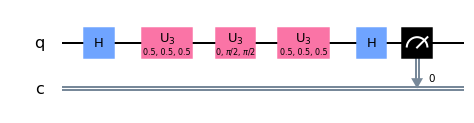

In [49]:
def variationalCircuit(params):
    
    q = QuantumRegister(1, 'q')
    c = ClassicalRegister(1, 'c')
    qc = QuantumCircuit(q, c, name = 'variationalCircuit')
    qc.h(0)
    qc.u3(params[0], params[1], params[2], 0)
    qc.u3(paramsA[0], paramsA[1], paramsA[2], 0)
    qc.u3(params[0], params[1], params[2], 0)
    qc.h(0)
    qc.measure(q[0], c[0])
    return qc
    
variationalCircuit([0.5, 0.5, 0.5]).draw('mpl')

In [50]:
def objective_function(params):
    
    q = QuantumRegister(1, 'q')
    c = ClassicalRegister(1, 'c')
    qc = QuantumCircuit(q, c, name = 'objective_function')
    
    qc.append(variationalCircuit(params), range(1), range(1))
    
    from qiskit import Aer, execute
    simulator = Aer.get_backend('qasm_simulator')
    counts = execute(qc, backend=simulator, shots=nShots).result().get_counts(qc)
    
    if '0' not in counts:
        counts['0'] = 0
        
    if '1' not in counts:
        counts['1'] = 0
    
    cost = (counts['1'] - 0) 
    
    return cost


#objective_function([0.5, 0.5, 0.5], A, 1000).draw('mpl')

In [51]:
from qiskit.aqua.components.optimizers import COBYLA

optimizer = COBYLA(maxiter=10000, tol=0.001/nShots)

params = np.random.rand(3)
ret = optimizer.optimize(num_vars=3, objective_function=objective_function, initial_point=params)

element11 = cmath.cos(ret[0][0]/2)
element12 = cmath.exp(-1J*ret[0][2])*cmath.sin(ret[0][0]/2)
element21 = cmath.exp(1J*ret[0][1])*cmath.sin(ret[0][0]/2)
element22 = cmath.exp(1J*(ret[0][1] + ret[0][2]))*cmath.cos(ret[0][0]/2)

#normalizingFactor = 1.0

eigen1 = (element11 + element12)/np.sqrt(2)
eigen2 = (element21 + element22)/np.sqrt(2)

norm = pow(np.abs(eigen1), 2) + pow(np.abs(eigen2), 2) 
normalizingFactor = math.sqrt(norm)

eigenvector = [[(eigen1)/normalizingFactor], [(eigen2)/normalizingFactor]]

diff1 = np.array(true_value1) - np.array(eigenvector)
diff2 = np.array(true_value2) - np.array(eigenvector)

print("Output Error (Manhattan Distance):", ret[1])
print("\nParameters Found:", ret[0])
print("\nNorm:", norm)
print("\nEigenvector Found:", eigenvector)
print("\nDifference:", diff1, "\n\n", diff2)

Output Error (Manhattan Distance): 0.0

Parameters Found: [ 0.0024519   1.9782506  -0.40358949]

Norm: 1.0022549046048517

Eigenvector Found: [[(0.7071066994168789+0.00034005847681330625j)], [(-0.0030728652037320357+0.7071001042988464j)]]

Difference: [[0.2928933 -3.40058477e-04j]
 [0.00307287-7.07100104e-01j]] 

 [[-0.7071067 -3.40058477e-04j]
 [ 1.00307287-7.07100104e-01j]]


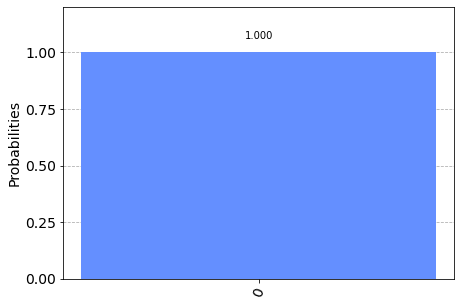

In [52]:
qc = variationalCircuit(ret[0])
simulator = Aer.get_backend('qasm_simulator')
counts = execute(qc, backend=simulator, shots=nShots).result().get_counts(qc)
plot_histogram(counts)